Lab 6: Animal movement data -- accelerometers
==============

In this lab we will analyse animal movement data, measured from accelerometers attached to animals. We will be analysing the movements of whales to try and infer what they are doing from one moment to another - in other words, **classifying behaviour states**, from a list of descriptive labels "rest", "travel", "exploratory", "feed".

The data file is `formatted_friedlaender_whales.zip` (180MB) which you can download from https://surfdrive.surf.nl/files/index.php/s/V5ndk9zBbb2o552 It comes from a larger dataset called BEBE https://zenodo.org/record/7947104 which is described in this paper https://arxiv.org/abs/2305.10740

The authors collected together multiple datasets, formatted them, and specified a 5-fold crossvalidation split. We will use their whales dataset.

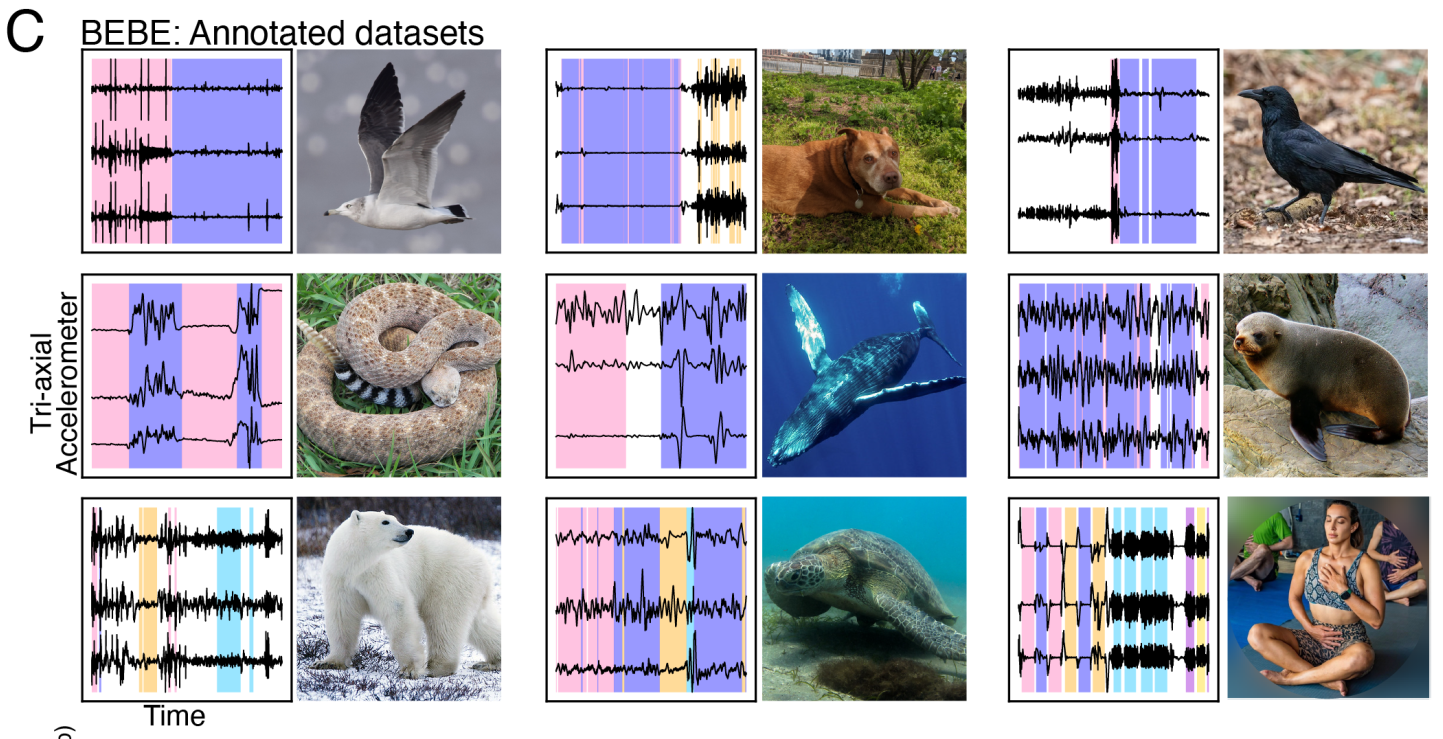

Their data is arranged as follows: In the "clip_data" folder there are 8 CSVs, each one representing **3-axis accelerometer** data recorded from an individual whale. The CSVs do NOT have headers. We need to load the YAML metadata file, `dataset_metadata.yaml` to know the column names AND to know which CSV belongs in which fold.

You can look at the content of `dataset_metadata.yaml`. It should help to understand the dataset.

In [1]:
%matplotlib inline
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [2]:
# CHANGE THIS
rootdir = "datasets/formatted_friedlaender_whales"

with open(os.path.join(rootdir, "dataset_metadata.yaml"), 'r') as file:
    meta = yaml.safe_load(file)
    
meta

{'clip_column_names': ['AccX',
  'AccY',
  'AccZ',
  'Depth',
  'Speed',
  'individual_id',
  'label'],
 'clip_id_to_individual_id': {'mn09_127a': 0,
  'mn09_148a': 1,
  'mn09_152a': 2,
  'mn10_132a': 3,
  'mn10_133a': 4,
  'mn10_139a': 5,
  'mn10_144a': 6,
  'mn10_151a': 7},
 'clip_ids': ['mn09_127a',
  'mn09_148a',
  'mn09_152a',
  'mn10_132a',
  'mn10_133a',
  'mn10_139a',
  'mn10_144a',
  'mn10_151a'],
 'clip_ids_per_fold': {0: ['mn09_127a', 'mn10_139a'],
  1: ['mn09_148a', 'mn10_144a'],
  2: ['mn09_152a', 'mn10_151a'],
  3: ['mn10_132a'],
  4: ['mn10_133a']},
 'dataset_name': 'friedlaender_whales',
 'individual_ids': [0, 1, 2, 3, 4, 5, 6, 7],
 'individuals_per_fold': {0: [0, 5], 1: [1, 6], 2: [2, 7], 3: [3], 4: [4]},
 'label_names': ['unknown', 'rest', 'travel', 'exploratory', 'feed'],
 'mean_dur_sec_by_individual': {0: 228.65999999999997,
  1: 95.61751527494907,
  2: 66.57073170731708,
  3: 138.4298578199052,
  4: 186.92107623318384,
  5: 137.63088235294117,
  6: 108.021825396825

Write code that uses pandas to load all 8 of the data CSVs into memory. We will need to access each dataset separately, so load them into a python dictionary so that you can later access them as `tsdata[clip_id]` and so forth. Use `pandas.read_csv()` but note that you'll need to use the `names` argument to specify the column names, since the column names are *in the YAML* but not in the CSVs themselves. Also use the `dtype` argument and the `dtypes` dict I provided, to ensure that some of the columns are interpreted as integers.

In [3]:
tsdata = {}

dtypes = {'individual_id':'int', 'label':'int'}

# your code here

clip_column_names = meta['clip_column_names']

csv_filenames = [f for f in os.listdir(os.path.join(rootdir, "clip_data/")) if f.endswith('.csv')]

csv_files = {
    clip_id: os.path.join(rootdir, "clip_data/", file_path) for clip_id, file_path in enumerate(csv_filenames)
}

# Load each CSV into the dictionary with its respective key
for clip_id, file_path in csv_files.items():
    tsdata[clip_id] = pd.read_csv(file_path, names=clip_column_names, dtype=dtypes)

In [4]:
# After your code, we can summarise what we loaded:
for clip_id, ts in tsdata.items():
    print(clip_id)
    print(ts.info())
    print()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422046 entries, 0 to 422045
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   AccX           422046 non-null  float64
 1   AccY           422046 non-null  float64
 2   AccZ           422046 non-null  float64
 3   Depth          422046 non-null  float64
 4   Speed          422046 non-null  float64
 5   individual_id  422046 non-null  int64  
 6   label          422046 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 22.5 MB
None

1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409164 entries, 0 to 409163
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   AccX           409164 non-null  float64
 1   AccY           409164 non-null  float64
 2   AccZ           409164 non-null  float64
 3   Depth          409164 non-null  float64
 4   Speed          409164 non-null  float64

Write code to measure what fraction of the data is labelled as "unknown" in each of our time-series -- this is one of the labels but it really indicates missing data, for moments of unknown behaviour.

In [5]:
# Your code here
for i in range(8):
    print(sum(tsdata[i]['label'] == "unknown"))


0
0
0
0
0
0
0
0


Plot, for one of the datasets, the first 1000 rows as a time-series plot. (The time series are quite long, don't plot a full one.)

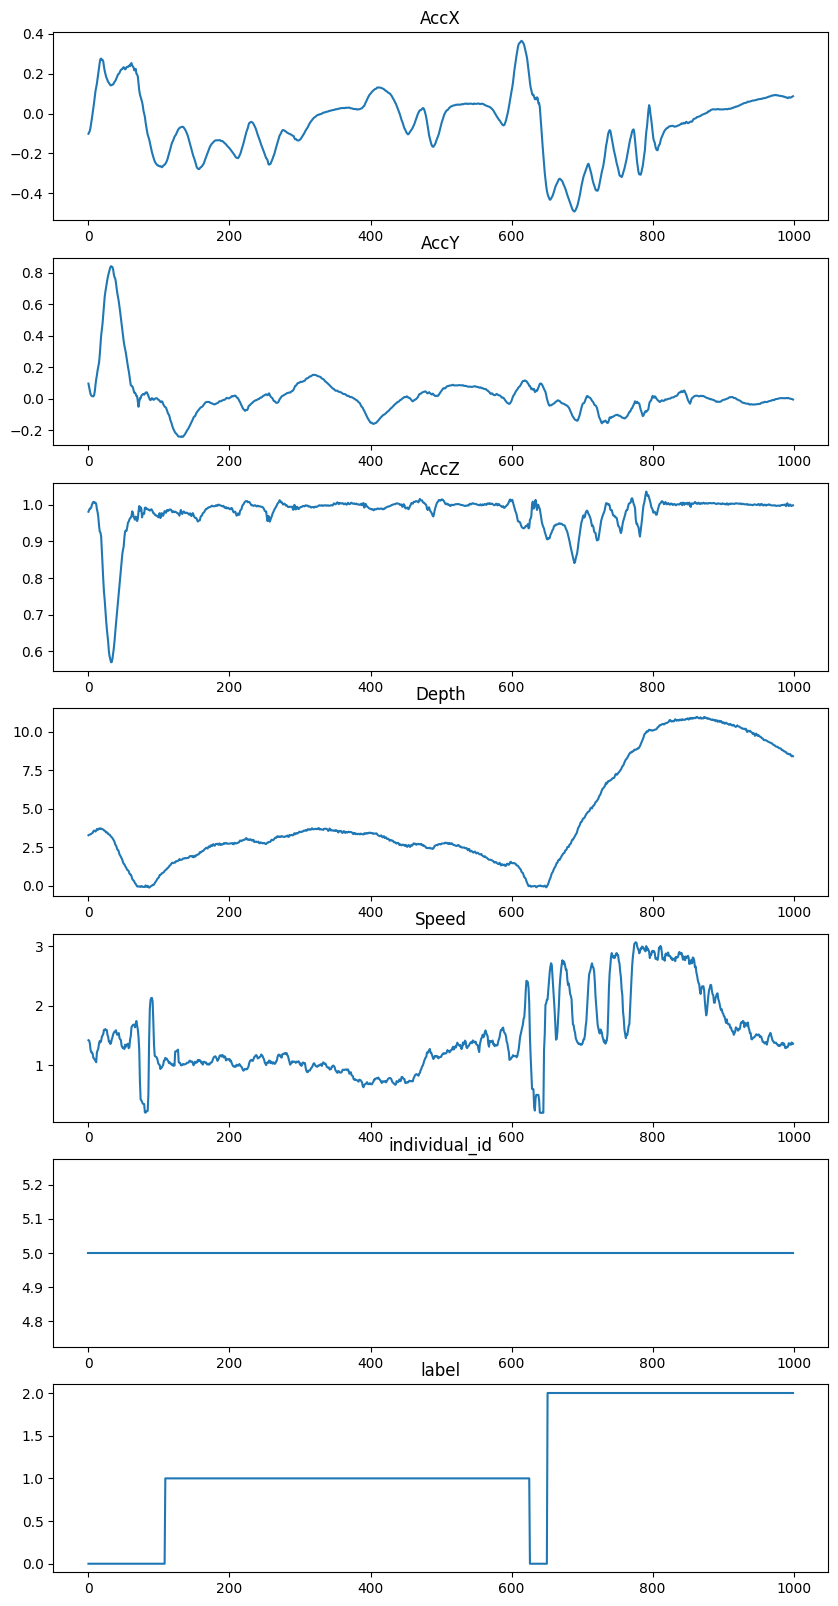

In [6]:
# Your code here
fig, axs = plt.subplots(7, 1, figsize=(10, 20))
for i in clip_column_names:
    axs[clip_column_names.index(i)].plot(tsdata[4][i].head(1000))
    axs[clip_column_names.index(i)].set_title(i)


Do any of the 5 time-series features seem to have a clear direct connection with the behavioural state (the "label" column)?

In [7]:
# Depth seems to be connected to the label, while other features are not
# for label 0 depth is the lowest, for label 1 depth is at the middle, for label 2 depth is at the highest of the ranges observed for this given clip

Lab 6 part b: Train machine learning
-------------------
First let's train a model that makes a direct regression between the instantaneous feature values and the label. This is simple: we treat each row as a separate data point, ignoring the fact the data are connected in time. Let's start by training `LogisticRegression(solver='liblinear')` which is quick and robust to train.

Implement 5-fold crossvalidation *as specified in the YAML data* - do NOT choose yor own train-test splits. The metadata file will help you. Remember that for each fold, you need to use 4 parts of the dataset to train, and 1 to test.

When your **training** fold contains more than 1 time-series, you can concatentate them all together as a training set using `pd.concat`.

To test each classifier, evaluate using the F-score `f1_score(....., average='micro')`, and then calculate & report the average across all folds.

Make sure to **ignore** rows with "unknown" category when you are evaluating the test set, because it's not clear what the true label should be, so we need to avoid using it for testing.

In [8]:
# This is the classifier you should use!
# SGDClassifier with log loss is the same as logistic regression,
#     but using less memory
def initialise_classifier():
    clf = SGDClassifier(loss='log_loss', max_iter=100)
    return clf


# Your code here:

# the folds from yaml 
folds = meta['individuals_per_fold']
nums8 = list(range(8))

# import time to measure the time it takes to run the cross validation
import time

def cv_split_eval(folds, nums8):
    for i in range(5):
        start = time.time()
        train_nums = [x for x in nums8 if x not in folds[i]]
        test_nums = folds[i]
        train = pd.concat([tsdata[j] for j in train_nums])
        test = pd.concat([tsdata[j] for j in test_nums])
        X_train = train.drop(columns=['label'])
        y_train = train['label']
        X_test = test.drop(columns=['label'])
        y_test = test['label']
        clf = initialise_classifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        fscores = []
        fscores.append(f1_score(y_test, y_pred, average='micro'))
        end = time.time() - start
        print(f'Fold {i}, time {end} s, F1 Score: {fscores[0]}')
    return fscores

In [9]:
cv_split_eval(folds, nums8)

KeyboardInterrupt: 

Next you need to CHOOSE your own way to improve performance by improving the features that are used.
* Including some previous/future information, e.g. the data from the [t-1] and [t+1] timestep, or more. (*One way to do this in pandas is by "shifting" data, something like `data[col].shift(1, fill_value=0)`*)
*  Including some summary statistics of the data in a local time window, for example the mean or median of a feature in the [t-k] to [t+k] region, or even the standard deviation, kurtosis, skew, autocorrelation... (*One way to do this in pandas is using it's "rolling" calculation, something like `data[col].rolling(8, min_periods=1, center=True).mean()`*)
* Preprocessing the features in some way
* Calculating "delta" values (the difference between adjacent time-steps)
* ...or something else you'd like to try

Implement your feature-processing, and re-run your experiment.

In [14]:
feature_cols

['AccX', 'AccY', 'AccZ', 'Depth', 'Speed', 'individual_id']

In [10]:
# Your code here
shift_size = 20
window_size = 10

for i in range(8):
    tsdata[i]['Depth_lag'] = tsdata[i]['Depth'].shift(shift_size, fill_value=tsdata[i]['Depth'].mean())
    #tsdata[i]['Depth_lead'] = tsdata[i]['Depth'].shift(-shift_size, fill_value=tsdata[i]['Depth'].mean())
    #tsdata[i]['Depth_rolling_mean'] = tsdata[i]['Depth'].rolling(window_size, min_periods=1).mean()
    #tsdata[i]['Depth_rolling_std'] = tsdata[i]['Depth'].rolling(window_size, min_periods=1).std()

cv_split_eval(folds, nums8)

Fold 0, time 69.33968901634216 s, F1 Score: 0.40098374472042475


KeyboardInterrupt: 

You can go through this a couple of times to try different feature-processing. Please report back to us about what DOES work well and what DOESN'T.

In [ ]:
# Your code here



OPTIONAL EXTRAS: If you would like to go further in this work:

1. Re-run your code using one of the other "formatted" datasets from the BEBE repository: https://zenodo.org/record/7947104
2. The team that created this dataset used F1 score for evaluation, but also added their new evaluation measure the "time scale ratio" (TSR). Take their TSR implementation code from https://github.com/earthspecies/BEBE and use it to evaluate your own models.
3. Try alternative classifiers. What would be better for this task?